In [1]:
# If you haven't installed the bwb package yet, run the following command
# !pip install git+https://github.com/ottomossei/bwb
import warnings
warnings.simplefilter('ignore')

## import modules

In [2]:
import datetime
from backtesting.lib import crossover

from bwb.db import LocalDB
import bwb.customstrategy as cst
import bwb.indicator as indicator

Loading BokehJS ...

## Target issue

In [3]:
issues = ['AAPL']
d = LocalDB()

In [4]:
# 自分でカスタマイズできるストラテジのクラス
class MyStrategy(cst.CustomStrategy):
    # 今回のストラテジで用いるインジケーターの宣言と設定
    def init(self):
        self.macd, self.macdsignal = self.I(indicator.macd, self.candle, day_short=9, day_long=26, span=9)

    # 売買設定
    def next(self):
        if crossover(self.macd, self.macdsignal):
            self.buy()
        elif crossover(self.macdsignal, self.macd):
            self.position.close()

In [5]:
# いくつも定義できる
class YourStrategy(cst.CustomStrategy):
    # 今回のストラテジで用いるインジケーターの宣言と設定
    def init(self):
        # 利用するMACDの定義
        self.macd, self.macdsignal = self.I(indicator.macd, self.candle, day_short=9, day_long=26, span=9)
        # 利用するボリンジャーバンドの定義
        self.upper, self.lower = self.I(indicator.ci, self.candle, day=20, upper_sigma=1, lower_sigma=1)

    # 売買設定
    def next(self):
        if crossover(self.macd, self.macdsignal):
            self.buy()
        elif crossover(self.macdsignal, self.macd):
            if crossover(self.upper, self.data['Close']):
                self.position.close()

In [6]:
# いくつも定義できる
class Day_5_Before_Strategy(cst.CustomStrategy):
    # 今回のストラテジで用いるインジケーターの宣言と設定
    def init(self):
        # 利用するMACDの定義
        self.macd, self.macdsignal = self.I(indicator.macd, self.candle, day_short=9, day_long=26, span=9)
        # 利用するボリンジャーバンドの定義
        self.upper, self.lower = self.I(indicator.ci, self.candle, day=20, upper_sigma=1, lower_sigma=1)

    # 売買設定
    def next(self):
        # print(len(self._indicators[0][0]))
        if crossover(self.macd, self.macdsignal):
            self.buy()
        elif crossover(self.macdsignal, self.macd):
            # if crossover(self.upper, self.data['Close']):
            if crossover(self._indicators[1][1][self.today-5], self.data['Close']):
                self.position.close()
        super().next()

In [7]:
# 銘柄ごとに処理の実行
for issue in issues:
    # 計算する銘柄の表示
    print(issue)
    candle = d.loader(issue, start = '2020-01-01', end = '2020-05-01')
    # Mystrategyの実行と保存
    MyStrategy.candle = candle
    d.runsaver(MyStrategy)
    # YourStrategyの実行と保存
    YourStrategy.candle = candle
    d.runsaver(YourStrategy)
    # Day_5_Before_Strategyの実行と保存
    Day_5_Before_Strategy.candle = candle
    output = d.runsaver(Day_5_Before_Strategy)

AAPL
AAPL


## Show with mplfinance

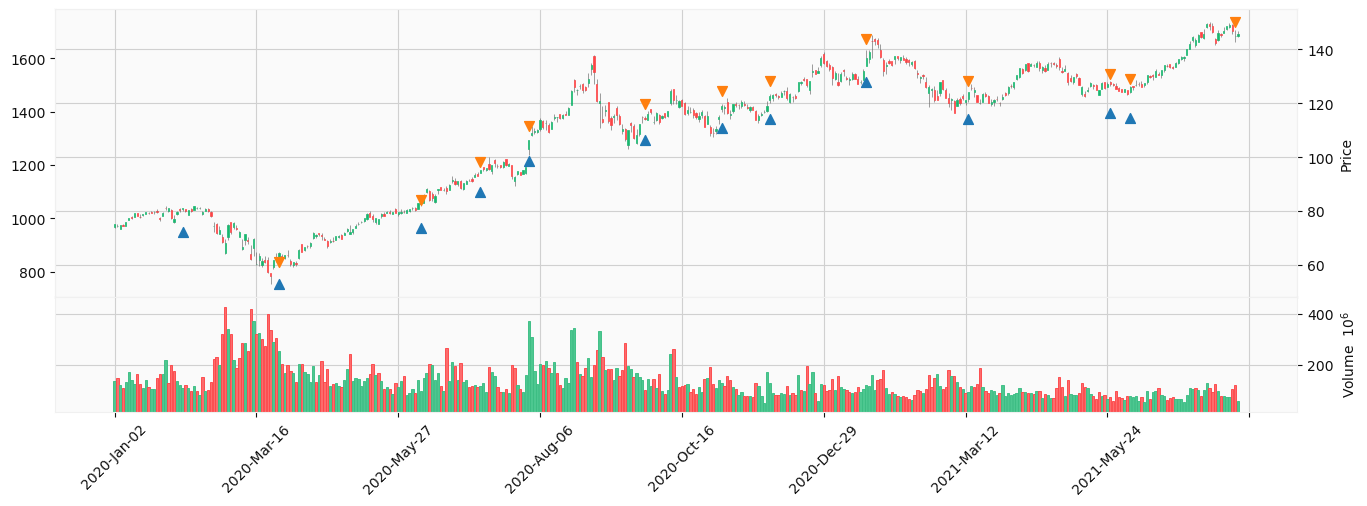

In [8]:
import mplfinance as mpf
import pandas as pd
buy = pd.DataFrame(data = output['_equity_curve']['Equity'][output['_trades']['EntryBar']]*0.95, index=output['_equity_curve'].index)
sell = pd.DataFrame(data = output['_equity_curve']['Equity'][output['_trades']['ExitBar']]*1.05, index=output['_equity_curve'].index)
# Show with Jupyter Notebook
apds = [mpf.make_addplot(buy,type='scatter',markersize=50,marker='^'),
        mpf.make_addplot(sell,type='scatter',markersize=50,marker='v')]

mpf.plot(candle, type='candle', figratio=(12,4),
         volume=True, style='yahoo', addplot=apds)